In [32]:
import numpy as np
import matplotlib.pyplot as plt

from dask.distributed import Client

from ase.build import bulk
from abtem import FrozenPhonons, SMatrix, Potential, GridScan, AnnularDetector, WavesDetector

import os
os.environ["MKL_NUM_THREADS"] = "1"

from abtem import config

config.set({'device': 'cpu'})
config.set({'fft': 'mkl'})
config.set({'lazy': True})

Runtime: 2.625 s per frozen phonon on 8-core Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz

In [2]:
client = Client()

C:\Users\jacob\anaconda3\envs\dask-gpu\lib\site-packages\distributed\node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 58785 instead
  warnings.warn(


In [33]:
atoms = bulk('Au', 'diamond', a=5.43, cubic=True)
atoms *= (5, 5, 5)

In [42]:
frozen_phonons = FrozenPhonons(atoms, 32, {'Au': .1})

potential = Potential(frozen_phonons, gpts=512, projection='infinite', slice_thickness=2)

probe = SMatrix(potential, energy=100e3, planewave_cutoff=20, chunks=100, interpolation=3)
scan = GridScan()

detectors = AnnularDetector(60, 150, ensemble_mean=True)

measurement = probe.scan(scan=scan, detectors=detectors, probes_per_reduction=100)

#measurement = probe.reduce(positions=scan, detectors=detectors, probes_per_reduction=300)
#measurement = probe.reduce(positions=scan, detectors=detectors, distribute_scan=(2,2))

In [24]:
#measurement.visualize_graph(optimize_graph=True, color='order')

In [43]:
%%time
measurement.compute()

Wall time: 1min 26s


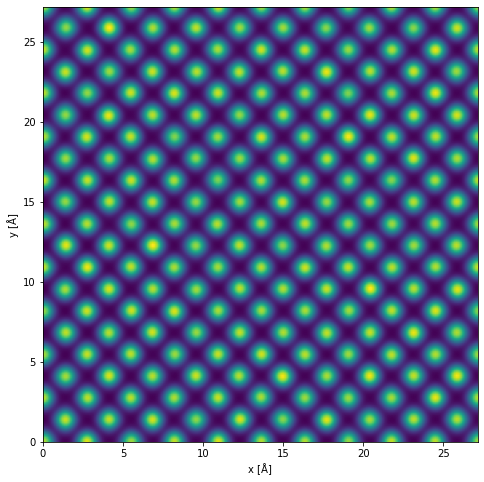

In [41]:
measurement.interpolate(.1).show(figsize=(8,8));